## Convolutional Neural Network for MNIST image classficiation 

In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Alternating Least Squares for Matrix Factorization

In [2]:
def coding_within_radius(X, W, H0, 
                         r=None, 
                         a1=0, #L1 regularizer
                         a2=0, #L2 regularizer
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + a1 * np.ones(len(idx))) + a2 * 2 * np.sign(H1[k,idx])
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size

            if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

In [3]:
def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

In [4]:
# Simulated Data and its factorization 

W0 = np.random.rand(10,5)
H0 = np.random.rand(5,20)
X0 = W0 @ H0

W, H = ALS(X=X0, 
           n_components=5, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

print('reconstruction error (relative) = %f' % (np.linalg.norm(X0-W@H)**2/np.linalg.norm(X0)**2))
print('Dictionary error (relative) = %f' % (np.linalg.norm(W0 - W)**2/np.linalg.norm(W0)**2))
print('Code error (relative) = %f' % (np.linalg.norm(H0-H)**2/np.linalg.norm(H0)**2))


 20%|████████████████                                                                | 20/100 [00:00<00:00, 194.70it/s]

iteration 0, reconstruction error 6.787943
iteration 10, reconstruction error 0.958406
iteration 20, reconstruction error 0.764181
iteration 30, reconstruction error 0.715136


 57%|█████████████████████████████████████████████▌                                  | 57/100 [00:00<00:00, 181.50it/s]

iteration 40, reconstruction error 0.678438
iteration 50, reconstruction error 0.646046
iteration 60, reconstruction error 0.614531
iteration 70, reconstruction error 0.588064


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 178.33it/s]

iteration 80, reconstruction error 0.565881
iteration 90, reconstruction error 0.547856
reconstruction error (relative) = 0.002059
Dictionary error (relative) = 0.894577
Code error (relative) = 19.518191


# Learn dictionary of MNIST images 

In [5]:
def display_dictionary(W, save_name=None, score=None, grid_shape=None):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=(6, 6)
    if (score is not None) and (grid_shape is None):
       figsize0=(6, 7)
    if (score is not None) and (grid_shape is not None):
       figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [6]:
def display_dictionary_list(W_list, label_list, save_name=None, score_list=None):
    # Make plot
    
    # outer gridspec
    nrows=1
    ncols=len(W_list)
    fig = plt.figure(figsize=(16, 5), constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.05)

    
    
    # make nested gridspecs
    for i in range(1 * ncols):
        k = int(np.sqrt(W_list[i].shape[0]))
        sub_rows = int(np.sqrt(W_list[i].shape[1]))
        sub_cols = int(np.sqrt(W_list[i].shape[1]))

        idx = np.arange(W_list[i].shape[1])
        if score_list is not None:
            idx = np.argsort(score_list[i])
            idx = np.flip(idx)    
        
        inner_grid = outer_grid[i].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

        for j in range(sub_rows*sub_cols):
            a = j // sub_cols 
            b = j % sub_cols #sub-lattice indices

            ax = fig.add_subplot(inner_grid[a, b])
            ax.imshow(W_list[i].T[idx[j]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xticks([])
            if (b>0):
                ax.set_yticks([])
            if (a < sub_rows-1):
                ax.set_xticks([])
            if (a == 0) and (b==2):
                #ax.set_title("W_nonnegativity$=$ %s \n H_nonnegativity$=$ %s" 
                #             % (str(nonnegativity_list[i][0]), str(nonnegativity_list[i][1])), y=1.2, fontsize=14) 
                ax.set_title(label_list[i], y=1.2, fontsize=14)
            if (score_list is not None) and (score_list[i] is not None):
                ax.set_xlabel('%1.2f' % score_list[i][idx[j]], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.07)
           
                
                
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.savefig(save_name, bbox_inches='tight')

In [7]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

  2%|█▋                                                                                 | 1/50 [00:00<00:05,  8.22it/s]

iteration 0, reconstruction error 6219.741838


 24%|███████████████████▋                                                              | 12/50 [00:01<00:03,  9.79it/s]

iteration 10, reconstruction error 1826.995178


 44%|████████████████████████████████████                                              | 22/50 [00:02<00:02,  9.34it/s]

iteration 20, reconstruction error 1490.684239


 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:03<00:01,  9.04it/s]

iteration 30, reconstruction error 1335.195267


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:04<00:00,  8.06it/s]

iteration 40, reconstruction error 1244.320652


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.99it/s]


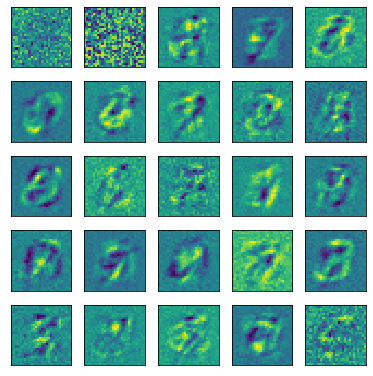

In [8]:
# Unconstrained matrix factorization and dictionary images 

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           W_nonnegativity=False,
           H_nonnegativity=False,
           compute_recons_error=True)

display_dictionary(W)

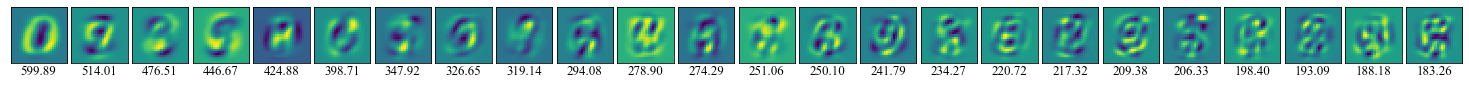

In [9]:
# PCA and dictionary images (principal components)

pca = PCA(n_components=24)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "MNIST_PCA_ex1.pdf", grid_shape=[1,24])

 20%|████████████████▌                                                                  | 2/10 [00:00<00:00,  9.02it/s]

iteration 0, reconstruction error 6566.587357


 20%|████████████████▌                                                                  | 2/10 [00:00<00:00, 10.46it/s]

iteration 0, reconstruction error 4840.248832


 20%|████████████████▌                                                                  | 2/10 [00:00<00:00,  8.91it/s]

iteration 0, reconstruction error 4879.197522


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.69it/s]


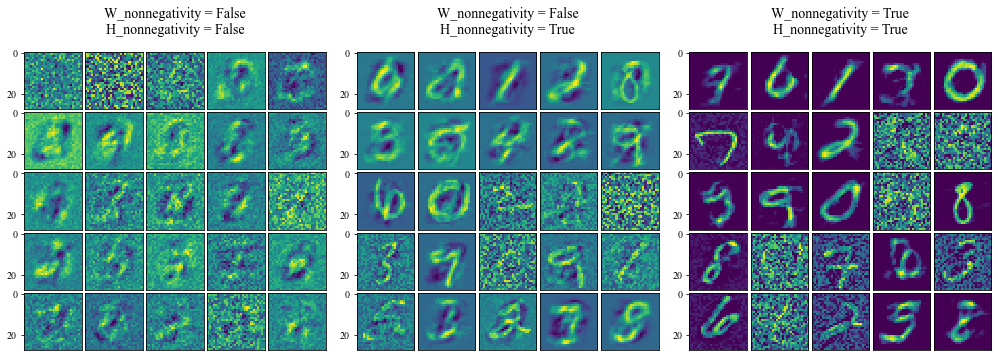

In [10]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 10
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    


label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex1.pdf")



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]
iteration 0, reconstruction error 6301.661654


 12%|█████████▋                                                                       | 12/100 [00:01<00:08,  9.86it/s]

iteration 10, reconstruction error 1832.463230


 22%|█████████████████▊                                                               | 22/100 [00:02<00:08,  9.54it/s]

iteration 20, reconstruction error 1526.140645


 32%|█████████████████████████▉                                                       | 32/100 [00:03<00:07,  9.36it/s]

iteration 30, reconstruction error 1381.146556


 42%|██████████████████████████████████                                               | 42/100 [00:04<00:06,  9.50it/s]

iteration 40, reconstruction error 1294.179500


 52%|██████████████████████████████████████████                                       | 52/100 [00:05<00:05,  9.46it/s]

iteration 50, reconstruction error 1238.276187


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:06<00:04,  8.93it/s]

iteration 60, reconstruction error 1200.863467


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:07<00:03,  9.17it/s]

iteration 70, reconstruction error 1176.135731


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:08<00:02,  9.32it/s]

iteration 80, reconstruction error 1160.035976


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:09<00:00,  8.62it/s]

iteration 90, reconstruction error 1149.040028


  1%|▊                                                                                 | 1/100 [00:00<00:12,  8.15it/s]

!!! nonnegativitiy[i] [False, True]
iteration 0, reconstruction error 4818.429401


 12%|█████████▋                                                                       | 12/100 [00:01<00:10,  8.59it/s]

iteration 10, reconstruction error 1595.852097


 22%|█████████████████▊                                                               | 22/100 [00:02<00:09,  8.42it/s]

iteration 20, reconstruction error 1159.566106


 32%|█████████████████████████▉                                                       | 32/100 [00:03<00:09,  7.43it/s]

iteration 30, reconstruction error 1046.865375


 42%|██████████████████████████████████                                               | 42/100 [00:05<00:07,  7.56it/s]

iteration 40, reconstruction error 1009.779818


 52%|██████████████████████████████████████████                                       | 52/100 [00:06<00:06,  7.81it/s]

iteration 50, reconstruction error 993.700698


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:07<00:04,  8.50it/s]

iteration 60, reconstruction error 985.860148


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:08<00:02,  9.47it/s]

iteration 70, reconstruction error 981.602490


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:09<00:02,  8.02it/s]

iteration 80, reconstruction error 978.972561


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:11<00:00,  8.34it/s]

iteration 90, reconstruction error 977.220519


  1%|▊                                                                                 | 1/100 [00:00<00:11,  8.76it/s]

!!! nonnegativitiy[i] [True, True]
iteration 0, reconstruction error 4857.643722


 12%|█████████▋                                                                       | 12/100 [00:01<00:09,  8.89it/s]

iteration 10, reconstruction error 2067.139782


 22%|█████████████████▊                                                               | 22/100 [00:02<00:09,  8.66it/s]

iteration 20, reconstruction error 1847.574105


 32%|█████████████████████████▉                                                       | 32/100 [00:03<00:07,  8.54it/s]

iteration 30, reconstruction error 1762.529971


 42%|██████████████████████████████████                                               | 42/100 [00:04<00:06,  8.50it/s]

iteration 40, reconstruction error 1695.938899


 52%|██████████████████████████████████████████                                       | 52/100 [00:06<00:06,  7.79it/s]

iteration 50, reconstruction error 1670.582255


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:07<00:04,  8.26it/s]

iteration 60, reconstruction error 1657.348973


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:08<00:03,  7.95it/s]

iteration 70, reconstruction error 1650.657013


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:09<00:02,  7.67it/s]

iteration 80, reconstruction error 1638.868467


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:11<00:00,  8.30it/s]

iteration 90, reconstruction error 1607.074510


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.31it/s]


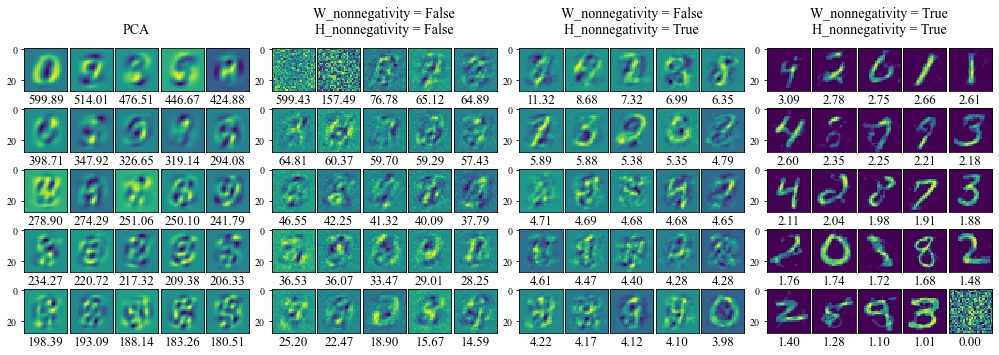

In [11]:
# MF and PCA on MNIST

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex1.pdf")



In [12]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [13]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

  2%|█▋                                                                                | 2/100 [00:00<00:13,  7.06it/s]

iteration 0, reconstruction error 12872.256505


 11%|████████▉                                                                        | 11/100 [00:01<00:14,  6.01it/s]

iteration 10, reconstruction error 4393.441132


 22%|█████████████████▊                                                               | 22/100 [00:03<00:13,  5.58it/s]

iteration 20, reconstruction error 3608.163232


 32%|█████████████████████████▉                                                       | 32/100 [00:05<00:11,  5.87it/s]

iteration 30, reconstruction error 3273.108473


 41%|█████████████████████████████████▏                                               | 41/100 [00:06<00:10,  5.61it/s]

iteration 40, reconstruction error 3078.384617


 52%|██████████████████████████████████████████                                       | 52/100 [00:08<00:08,  5.33it/s]

iteration 50, reconstruction error 2946.261308


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:10<00:06,  5.85it/s]

iteration 60, reconstruction error 2854.015582


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:11<00:04,  6.10it/s]

iteration 70, reconstruction error 2786.607147


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:13<00:03,  5.93it/s]

iteration 80, reconstruction error 2733.992648


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:15<00:01,  6.29it/s]

iteration 90, reconstruction error 2691.092881


  2%|█▋                                                                                | 2/100 [00:00<00:15,  6.15it/s]

iteration 0, reconstruction error 7829.196492


 11%|████████▉                                                                        | 11/100 [00:01<00:14,  5.97it/s]

iteration 10, reconstruction error 4411.871975


 22%|█████████████████▊                                                               | 22/100 [00:04<00:13,  5.71it/s]

iteration 20, reconstruction error 3159.167966


 32%|█████████████████████████▉                                                       | 32/100 [00:05<00:11,  5.97it/s]

iteration 30, reconstruction error 2615.380165


 42%|██████████████████████████████████                                               | 42/100 [00:07<00:09,  5.94it/s]

iteration 40, reconstruction error 2427.373149


 52%|██████████████████████████████████████████                                       | 52/100 [00:09<00:07,  6.12it/s]

iteration 50, reconstruction error 2361.093779


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:10<00:06,  5.91it/s]

iteration 60, reconstruction error 2326.009110


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:12<00:04,  6.01it/s]

iteration 70, reconstruction error 2302.737799


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:13<00:03,  6.08it/s]

iteration 80, reconstruction error 2285.969718


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:15<00:01,  5.77it/s]

iteration 90, reconstruction error 2273.517537


  1%|▊                                                                                 | 1/100 [00:00<00:18,  5.48it/s]

iteration 0, reconstruction error 7882.703749


 12%|█████████▋                                                                       | 12/100 [00:02<00:14,  6.13it/s]

iteration 10, reconstruction error 5071.357724


 22%|█████████████████▊                                                               | 22/100 [00:03<00:12,  6.33it/s]

iteration 20, reconstruction error 4299.850786


 32%|█████████████████████████▉                                                       | 32/100 [00:05<00:11,  5.95it/s]

iteration 30, reconstruction error 3861.191287


 42%|██████████████████████████████████                                               | 42/100 [00:07<00:11,  5.16it/s]

iteration 40, reconstruction error 3711.178199


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:08<00:08,  5.46it/s]

iteration 50, reconstruction error 3475.822059


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:10<00:06,  5.92it/s]

iteration 60, reconstruction error 3390.850913


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:12<00:06,  4.69it/s]

iteration 70, reconstruction error 3373.919846


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:14<00:03,  5.65it/s]

iteration 80, reconstruction error 3366.171392


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:16<00:01,  5.91it/s]

iteration 90, reconstruction error 3342.152280


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


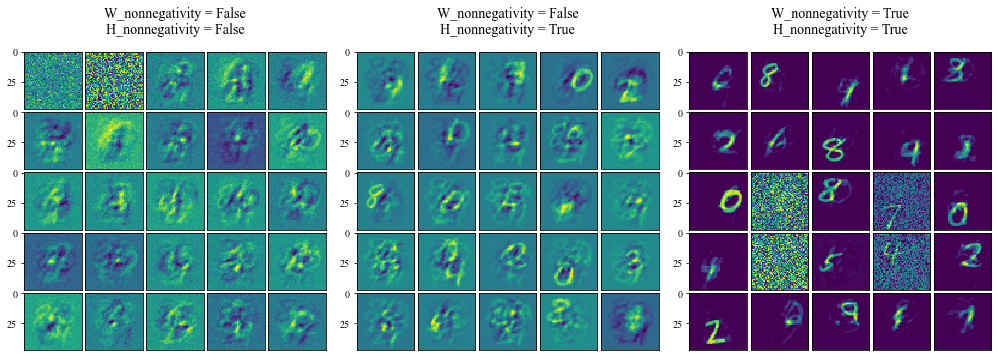

In [14]:
# Simple MNIST binary classification experiments 

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)


idx = np.random.choice(np.arange(X_train.shape[1]), 100)
X0 = X_train[idx,:].T

n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex2.pdf")

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [False, False]


  1%|▊                                                                                 | 1/100 [00:00<00:25,  3.90it/s]

iteration 0, reconstruction error 12852.671287


 12%|█████████▋                                                                       | 12/100 [00:02<00:16,  5.23it/s]

iteration 10, reconstruction error 4341.219066


 21%|█████████████████                                                                | 21/100 [00:04<00:13,  5.82it/s]

iteration 20, reconstruction error 3529.696225


 31%|█████████████████████████                                                        | 31/100 [00:06<00:13,  5.14it/s]

iteration 30, reconstruction error 3119.752152


 42%|██████████████████████████████████                                               | 42/100 [00:08<00:10,  5.39it/s]

iteration 40, reconstruction error 2878.701250


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:09<00:09,  5.22it/s]

iteration 50, reconstruction error 2748.838349


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:11<00:06,  5.79it/s]

iteration 60, reconstruction error 2673.845100


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:13<00:04,  6.30it/s]

iteration 70, reconstruction error 2625.562856


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:14<00:02,  6.30it/s]

iteration 80, reconstruction error 2593.271004


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:16<00:01,  5.44it/s]

iteration 90, reconstruction error 2568.279724


  1%|▊                                                                                 | 1/100 [00:00<00:16,  6.14it/s]

!!! nonnegativitiy[i] [False, True]
iteration 0, reconstruction error 7853.638429


 12%|█████████▋                                                                       | 12/100 [00:01<00:15,  5.86it/s]

iteration 10, reconstruction error 4331.105886


 21%|█████████████████                                                                | 21/100 [00:03<00:15,  5.21it/s]

iteration 20, reconstruction error 3266.765435


 32%|█████████████████████████▉                                                       | 32/100 [00:05<00:12,  5.54it/s]

iteration 30, reconstruction error 2691.325440


 42%|██████████████████████████████████                                               | 42/100 [00:07<00:10,  5.40it/s]

iteration 40, reconstruction error 2420.001911


 52%|██████████████████████████████████████████                                       | 52/100 [00:09<00:08,  5.40it/s]

iteration 50, reconstruction error 2314.588568


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:11<00:06,  5.75it/s]

iteration 60, reconstruction error 2274.124005


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:12<00:05,  5.46it/s]

iteration 70, reconstruction error 2251.425616


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:14<00:03,  5.67it/s]

iteration 80, reconstruction error 2235.185174


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:16<00:01,  5.46it/s]

iteration 90, reconstruction error 2222.508913


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

!!! nonnegativitiy[i] [True, True]


  2%|█▋                                                                                | 2/100 [00:00<00:18,  5.35it/s]

iteration 0, reconstruction error 7908.167185


 12%|█████████▋                                                                       | 12/100 [00:02<00:15,  5.81it/s]

iteration 10, reconstruction error 4994.251284


 21%|█████████████████                                                                | 21/100 [00:03<00:14,  5.63it/s]

iteration 20, reconstruction error 4298.436304


 31%|█████████████████████████                                                        | 31/100 [00:05<00:11,  5.85it/s]

iteration 30, reconstruction error 3968.799625


 42%|██████████████████████████████████                                               | 42/100 [00:07<00:10,  5.67it/s]

iteration 40, reconstruction error 3683.854229


 52%|██████████████████████████████████████████                                       | 52/100 [00:09<00:08,  5.70it/s]

iteration 50, reconstruction error 3428.581215


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:10<00:06,  5.84it/s]

iteration 60, reconstruction error 3277.781496


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:12<00:04,  5.71it/s]

iteration 70, reconstruction error 3206.607860


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:14<00:03,  5.83it/s]

iteration 80, reconstruction error 3176.851843


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:16<00:01,  5.61it/s]

iteration 90, reconstruction error 3109.258052


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.61it/s]


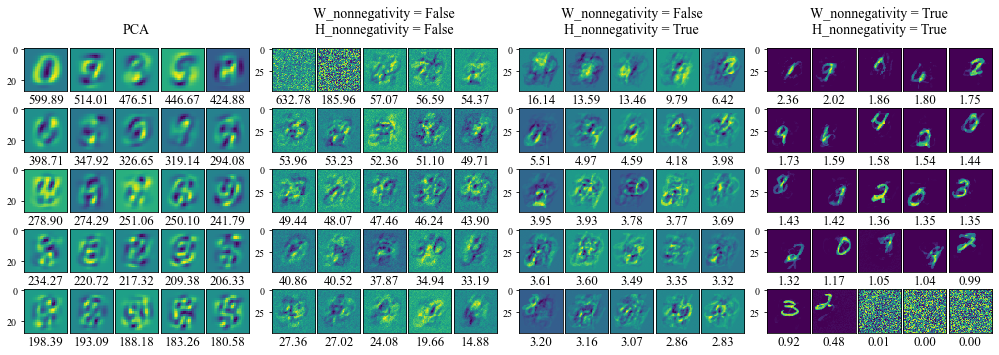

In [15]:
# MF and PCA on MNIST + padding

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)



idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X_train[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex2.pdf")



## Dictionary Learing for Face datasets

In [16]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
#faces_centered = faces - faces.mean(axis=0)

# local centering
#faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)


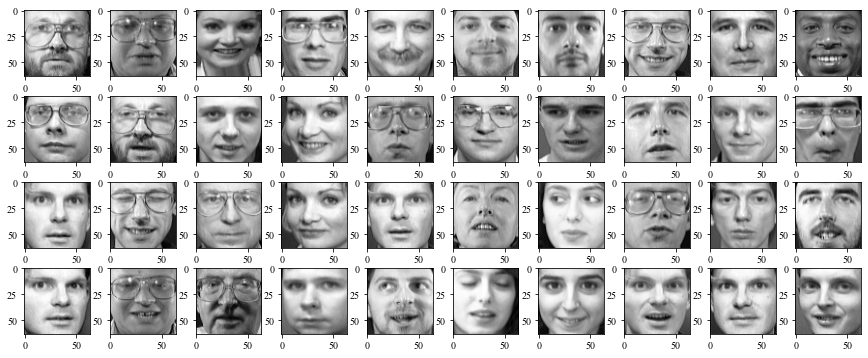

In [17]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        ax[i,j].imshow(faces[i*ncols + j].reshape(64,64), cmap="gray")
        #if i == 0:
        #    ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('Faces_ex1.pdf', bbox_inches='tight')

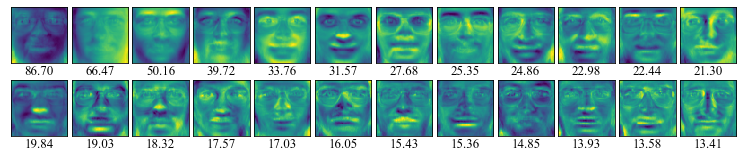

In [18]:
# PCA and dictionary images (principal components)

X0 = faces.T
pca = PCA(n_components=24)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "Faces_PCA_ex1.pdf", grid_shape=[2,12])

In [ ]:
# Variable nonnegativity constraints 

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

n_iter = 200
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex1.pdf")



  0%|▍                                                                                 | 1/200 [00:00<01:11,  2.77it/s]

iteration 0, reconstruction error 69974.735850


  6%|████▍                                                                            | 11/200 [00:04<01:16,  2.47it/s]

iteration 10, reconstruction error 15597.967166


 10%|████████▌                                                                        | 21/200 [00:08<01:06,  2.68it/s]

iteration 20, reconstruction error 12808.636956


 16%|████████████▌                                                                    | 31/200 [00:11<01:02,  2.70it/s]

iteration 30, reconstruction error 11682.927637


 20%|████████████████▌                                                                | 41/200 [00:15<01:05,  2.43it/s]

iteration 40, reconstruction error 10992.863024


 26%|████████████████████▋                                                            | 51/200 [00:19<00:59,  2.49it/s]

iteration 50, reconstruction error 10437.184823


 30%|████████████████████████▋                                                        | 61/200 [00:23<00:54,  2.54it/s]

iteration 60, reconstruction error 9957.591481


 36%|████████████████████████████▊                                                    | 71/200 [00:27<00:52,  2.48it/s]

iteration 70, reconstruction error 9545.023930


 40%|████████████████████████████████▊                                                | 81/200 [00:31<00:48,  2.44it/s]

iteration 80, reconstruction error 9207.614915


 46%|████████████████████████████████████▊                                            | 91/200 [00:35<00:42,  2.54it/s]

iteration 90, reconstruction error 8939.624983


 50%|████████████████████████████████████████▍                                       | 101/200 [00:39<00:37,  2.63it/s]

iteration 100, reconstruction error 8734.399572


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:43<00:33,  2.68it/s]

iteration 110, reconstruction error 8580.298962


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:47<00:30,  2.56it/s]

iteration 120, reconstruction error 8457.751065


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:50<00:26,  2.65it/s]

iteration 130, reconstruction error 8357.634164


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:54<00:23,  2.51it/s]

iteration 140, reconstruction error 8272.844236


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:58<00:19,  2.54it/s]

iteration 150, reconstruction error 8199.111576


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [01:02<00:14,  2.62it/s]

iteration 160, reconstruction error 8136.421907


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:06<00:11,  2.63it/s]

iteration 170, reconstruction error 8080.682383


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:09<00:06,  2.75it/s]

iteration 180, reconstruction error 8026.459230


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:13<00:03,  2.79it/s]

iteration 190, reconstruction error 7983.054094


  0%|▍                                                                                 | 1/200 [00:00<01:13,  2.70it/s]

iteration 0, reconstruction error 25358.602185


  6%|████▍                                                                            | 11/200 [00:04<01:10,  2.67it/s]

iteration 10, reconstruction error 8298.185276


 10%|████████▌                                                                        | 21/200 [00:07<01:09,  2.57it/s]

iteration 20, reconstruction error 7333.796546


 16%|████████████▌                                                                    | 31/200 [00:11<01:05,  2.57it/s]

iteration 30, reconstruction error 7056.691380


 20%|████████████████▌                                                                | 41/200 [00:17<01:14,  2.13it/s]

iteration 40, reconstruction error 6924.872108


 26%|████████████████████▋                                                            | 51/200 [00:21<01:06,  2.25it/s]

iteration 50, reconstruction error 6844.907560


 30%|████████████████████████▋                                                        | 61/200 [00:25<00:53,  2.60it/s]

iteration 60, reconstruction error 6803.418655


 36%|████████████████████████████▊                                                    | 71/200 [00:29<00:53,  2.42it/s]

iteration 70, reconstruction error 6781.291174


 40%|████████████████████████████████▊                                                | 81/200 [00:33<00:47,  2.49it/s]

iteration 80, reconstruction error 6765.537235


 46%|████████████████████████████████████▊                                            | 91/200 [00:37<00:42,  2.56it/s]

iteration 90, reconstruction error 6751.180847


 50%|████████████████████████████████████████▍                                       | 101/200 [00:41<00:42,  2.32it/s]

iteration 100, reconstruction error 6735.227656


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:46<00:38,  2.29it/s]

iteration 110, reconstruction error 6717.535514


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:50<00:34,  2.31it/s]

iteration 120, reconstruction error 6698.381245


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:54<00:27,  2.47it/s]

iteration 130, reconstruction error 6677.718378


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:58<00:21,  2.75it/s]

iteration 140, reconstruction error 6657.658101


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [01:01<00:18,  2.70it/s]

iteration 150, reconstruction error 6640.562432


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [01:05<00:14,  2.72it/s]

iteration 160, reconstruction error 6625.993658


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:09<00:10,  2.77it/s]

iteration 170, reconstruction error 6613.985187


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:12<00:06,  2.73it/s]

iteration 180, reconstruction error 6605.083967


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:16<00:03,  2.78it/s]

iteration 190, reconstruction error 6598.142089


  0%|▍                                                                                 | 1/200 [00:00<01:24,  2.35it/s]

iteration 0, reconstruction error 25350.496267


  6%|████▍                                                                            | 11/200 [00:04<01:15,  2.52it/s]

iteration 10, reconstruction error 9216.588918


 10%|████████▌                                                                        | 21/200 [00:08<01:09,  2.58it/s]

iteration 20, reconstruction error 8042.791015


 16%|████████████▌                                                                    | 31/200 [00:12<01:08,  2.45it/s]

iteration 30, reconstruction error 7646.898007


 20%|████████████████▏                                                                | 40/200 [00:16<01:05,  2.45it/s]

In [ ]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex1.pdf")

In [ ]:
# Variable regularizer for W

X0 = faces_centered.T
print('X0.shape', X0.shape)

n_iter = 200
W_list = []

W_sparsity = [[0, 0], [0.5, 0], [0, 3]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)

display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex2.pdf")

In [ ]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

W_sparsity = ['PCA', [0, 0], [0.5, 0], [0, 3]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)


label_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex2.pdf")

## Topic modeling for 20Newsgroups dataset

In [ ]:
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import entropy
import pandas as pd

In [ ]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [ ]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_labels = newsgroups_train.target
# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

# print 10 random documents
#for i in np.arange(10):
#    idx = np.random.choice(len(data_cleaned))
#    print('>>>> %i th doc \n\n %s \n\n' % (idx, data_cleaned[idx]))
    
print('len(newsgroups_labels)', len(newsgroups_labels))
print('newsgroups_labels', newsgroups_labels)

print('data_cleaned[1]', data_cleaned[1])
print('newsgroups_labels[1]', newsgroups_labels[1])

In [ ]:
# vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectorizer_BOW = CountVectorizer(stop_words=stopwords_list)
vectors_BOW = vectorizer_BOW.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
idx_to_word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

print('>>>> vectors.shape', vectors.shape)
i = 4257
print('newsgroups_labels[i]', newsgroups_labels[i])
print('>>>> data_cleaned[i]', data_cleaned[i])
# print('>>>> vectors[:,i] \n', vectors[:,i])


a = vectors[:,i].todense() 
I = np.where(a>0)

count_list = []
word_list = []

for j in np.arange(len(I[0])):
    # idx = np.random.choice(I[0])
    idx = I[0][j]
    # print('>>>> %i th coordinate <===> %s, count %i' % (idx, idx_to_word[idx], vectors[idx, i]))
    count_list.append([idx, vectors_BOW[idx, i], vectors[idx, i]])
    word_list.append(idx_to_word[idx])

d = pd.DataFrame(data=np.asarray(count_list).T, columns=word_list).T
d.columns = ['Coordinate', 'Bag-of-words', 'tf-idf']
cols = ['Coordinate', 'Bag-of-words']
d[cols] = d[cols].applymap(np.int64)

print(d)

In [ ]:
def sample_multiclass_20NEWS(list_classes=[0, 1], full_data=None, vectorizer = 'bag-of-words', verbose=True):
    # get train and test set from 20NewsGroups of given categories
    # vectorizer \in ['tf-idf', 'bag-of-words']
    # documents are loaded up from the following 10 categories
    categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'sci.med',
     'sci.space',
     'talk.politics.guns',
     'talk.politics.mideast',
     'talk.religion.misc'
     ]
    
    data_dict = {}
    data_dict.update({'categories': categories})
    
    if full_data is None:
        remove = ('headers','footers','quotes')
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])  
        
        newsgroups_train_full = fetch_20newsgroups(subset='train', categories=categories, remove=remove) # raw documents
        newsgroups_train = [re.sub(r'\d+','', file) for file in newsgroups_train_full.data] # remove numbers (we are only interested in words)
        y = newsgroups_train_full.target # document class labels 
        Y = list2onehot(y.tolist(), list_classes)
       
        
        if vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words=stopwords_list) 
        else:
            vectorizer = CountVectorizer(stop_words=stopwords_list) 
            
        X = vectorizer.fit_transform(newsgroups_train) # words x docs  # in the form of sparse matrix
        X = np.asarray(X.todense())
        print('!! X.shape', X.shape)
        idx2word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

        data_dict.update({'newsgroups_train': data_cleaned})
        data_dict.update({'newsgroups_labels': y})
        data_dict.update({'feature_matrix': vectors})
        data_dict.update({'idx2word': idx2word})
        
    else:
        X, y = full_data

    idx = [i for i in np.arange(len(y)) if y[i] in list_classes] # list of indices where the label y is in list_classes

    X01 = X[idx,:]
    Y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(Y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(Y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

# test 
X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=[0, 1, 2,3,4,5,6,7,8,9], 
                                                                       vectorizer = 'bag-of-words',
                                                                       full_data=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)
#print('y_list', onehot2list(y_test))

In [ ]:
idx2word = data_dict.get('idx2word')
categories = data_dict.get('categories')

In [ ]:
import random 

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def plot_topic_wordcloud(W, idx2word, num_keywords_in_topic=5, save_name=None, grid_shape = [2,5]):
        # plot the class-conditioanl PMF as wordclouds 
        # W = (p x r) (words x topic)
        # idx2words = list of words used in the vectorization of documents 
        # categories = list of class labels
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
             
        fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': []})
        for ax, i in zip(axs.flat, np.arange(W.shape[1])):
            # dist = W[:,i]/np.sum(W[:,i])

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            idx = np.argsort(W[:,i])
            idx = np.flip(idx)    
           
            for j in range(num_keywords_in_topic):
                list_words.append(idx2word[idx[j]])
                
            Y = " ".join(list_words)
            #stopwords = STOPWORDS
            #stopwords.update(["’", "“", "”", "000", "000 000", "https", "co", "19", "2019", "coronavirus",
            #                  "virus", "corona", "covid", "ncov", "covid19", "amp"])
            wc = WordCloud(background_color="black",
                                  relative_scaling=0,
                                  width=400,
                                  height=400).generate(Y)
            
            ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
                                 interpolation="bilinear")
            
            # ax.set_xlabel(categories[i], fontsize='20')
            # ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')

In [ ]:
X0 = X_train.T

print('X0.shape', X0.shape)

W, H = ALS(X=X0, 
           n_components=10, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=True,
           compute_recons_error=True)

plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, grid_shape=[2,5], save_name="20NEWS_topic1.pdf")

In [ ]:
# Topic modeling by NMF
X0 = X_train.T

W, H = ALS(X=X0, 
           n_components=10, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=False,
           compute_recons_error=True)


plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, grid_shape = [2,5], save_name="20NEWS_topic2.pdf")